In [16]:
pip install qai-hub

In [17]:
!qai-hub configure --api_token cf8ba555e15467857df748a6d168134528e94d81

qai-hub configuration saved to /root/.qai_hub/client.ini
==================== /root/.qai_hub/client.ini ====================
[api]
api_token = cf8ba555e15467857df748a6d168134528e94d81
api_url = https://app.aihub.qualcomm.com
web_url = https://app.aihub.qualcomm.com
verbose = True




In [18]:
import qai_hub as hub
hub.get_devices()

[Device(name='Google Pixel 3 (Family)', os='10', attributes=['os:android', 'framework:tflite', 'framework:onnx', 'abi:aarch64-android', 'vendor:google', 'format:phone', 'chipset:qualcomm-snapdragon-845', 'chipset:sdm845', 'hexagon:v65', 'soc-model:1']),
 Device(name='Google Pixel 3', os='10', attributes=['os:android', 'framework:tflite', 'framework:onnx', 'abi:aarch64-android', 'vendor:google', 'format:phone', 'chipset:qualcomm-snapdragon-845', 'chipset:sdm845', 'hexagon:v65', 'soc-model:1']),
 Device(name='Google Pixel 3a', os='10', attributes=['os:android', 'framework:tflite', 'framework:onnx', 'abi:aarch64-android', 'vendor:google', 'format:phone', 'chipset:qualcomm-snapdragon-670', 'chipset:sdm670', 'hexagon:v65', 'soc-model:6']),
 Device(name='Google Pixel 3 XL', os='10', attributes=['os:android', 'framework:tflite', 'framework:onnx', 'abi:aarch64-android', 'vendor:google', 'format:phone', 'chipset:qualcomm-snapdragon-845', 'chipset:sdm845', 'hexagon:v65', 'soc-model:1']),
 Device

In [19]:
!pip3 install "qai-hub[torch]"

In [20]:
import numpy as np
import requests
import torch
from PIL import Image
from torchvision.models import mobilenet_v3_small
import qai_hub as hub

# Using pre-trained MobileNet
torch_model = mobilenet_v3_small(pretrained=True)
torch_model.eval()

# Trace model
input_shape = (1, 3, 224, 224)
example_input = torch.rand(input_shape)
traced_torch_model = torch.jit.trace(torch_model, example_input)

# Compile model
compile_job = hub.submit_compile_job(
    model=traced_torch_model,
    device=hub.Device("Samsung Galaxy S24 (Family)"),
    input_specs=dict(image=input_shape),
    options="--target_runtime tflite",
)
assert isinstance(compile_job, hub.CompileJob)

# Profile on cloud-hosted device
target_model = compile_job.get_target_model()
assert isinstance(target_model, hub.Model)
profile_job = hub.submit_profile_job(
    model=target_model,
    device=hub.Device("Samsung Galaxy S24 (Family)"),
)
assert isinstance(profile_job, hub.ProfileJob)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 146MB/s]


Uploading tmpfva4uwxd.pt


100%|██████████| 10.2M/10.2M [00:02<00:00, 5.07MB/s]


Scheduled compile job (j5mez819p) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j5mez819p/

Waiting for compile job (j5mez819p) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
Scheduled profile job (jgn0ekdq5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgn0ekdq5/



In [21]:
# Run inference on cloud-hosted device
sample_image_url = (
    "https://qaihub-public-assets.s3.us-west-2.amazonaws.com/apidoc/input_image1.jpg"
)
response = requests.get(sample_image_url, stream=True)
response.raw.decode_content = True
image = Image.open(response.raw).resize((224, 224))
input_array = np.expand_dims(
    np.transpose(np.array(image, dtype=np.float32) / 255.0, (2, 0, 1)), axis=0
)

# Run inference using the on-device model on the input image
inference_job = hub.submit_inference_job(
    model=target_model,
    device=hub.Device("Samsung Galaxy S24 (Family)"),
    inputs=dict(image=[input_array]),
)
on_device_output = inference_job.download_output_data()

# Post-processing the on-device output
output_name = list(on_device_output.keys())[0]
out = on_device_output[output_name][0]
on_device_probabilities = np.exp(out) / np.sum(np.exp(out), axis=1)

# Read the class labels for imagenet
sample_classes = "https://qaihub-public-assets.s3.us-west-2.amazonaws.com/apidoc/imagenet_classes.txt"
response = requests.get(sample_classes, stream=True)
response.raw.decode_content = True
categories = [str(s.strip()) for s in response.raw]

# Print top five predictions for the on-device model
print("Top-5 On-Device predictions:")
top5_classes = np.argsort(on_device_probabilities[0], axis=0)[-5:]
for c in reversed(top5_classes):
    print(f"{c} {categories[c]:20s} {on_device_probabilities[0][c]:>6.1%}")

# Download model
target_model = compile_job.get_target_model()
target_model.download("mobilenet_v3.tflite")

Uploading dataset: 154kB [00:01, 134kB/s]                    


Scheduled inference job (jpr6ywm7p) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jpr6ywm7p/

Waiting for inference job (jpr6ywm7p) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


tmpb7020aio.h5: 100%|██████████| 14.4k/14.4k [00:00<00:00, 12.8MB/s]


Top-5 On-Device predictions:
967 b'espresso'           87.6%
968 b'cup'                 7.9%
504 b'coffee mug'          3.5%
969 b'eggnog'              0.3%
849 b'teapot'              0.2%


mobilenet_v3.tflite: 100%|██████████| 9.71M/9.71M [00:01<00:00, 8.80MB/s]

Downloaded model to mobilenet_v3.tflite


'mobilenet_v3.tflite'

In [2]:
!pip -q install qai-hub qai-hub-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 816.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   186M      0  0:00:04  0:00:04 --:--:--  186M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip

In [5]:
!ls PetImages

Cat  Dog


In [6]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 32
num_epochs = 5
learning_rate = 0.001
validation_split = 0.2

data_dir = 'PetImages'

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation: randomly flip images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset (ImageFolder automatically assigns classes in alphabetical order)
full_dataset = datasets.ImageFolder(data_dir)

# Splitting dataset into training and validation subsets
total_size = len(full_dataset)
val_size = int(total_size * validation_split)
train_size = total_size - val_size

train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(data_dir, transform=val_transform)

# Split the datasets using random_split
train_dataset, _ = random_split(train_dataset, [train_size, val_size])
_, valid_dataset = random_split(valid_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Load ResNet18 pre-trained on ImageNet
model = models.resnet18(pretrained=True)

for name, param in model.named_parameters():
    # Only unfreeze parameters in layer4 and fc
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace the final layer to suit our binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


In [10]:
# Loss and optimizer (all parameters with requires_grad=True will be updated)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds.double() / total_preds

        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels)
                total_preds += labels.size(0)

        valid_loss = running_loss / len(valid_loader)
        valid_accuracy = correct_preds.double() / total_preds

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy.item())
        valid_accuracies.append(valid_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs
)

Epoch 1/5
Train Loss: 0.0858, Train Acc: 0.9668
Valid Loss: 0.0431, Valid Acc: 0.9840
Epoch 2/5
Train Loss: 0.0550, Train Acc: 0.9810
Valid Loss: 0.0351, Valid Acc: 0.9891
Epoch 3/5
Train Loss: 0.0407, Train Acc: 0.9852
Valid Loss: 0.0253, Valid Acc: 0.9921
Epoch 4/5
Train Loss: 0.0309, Train Acc: 0.9883
Valid Loss: 0.0186, Valid Acc: 0.9947
Epoch 5/5
Train Loss: 0.0273, Train Acc: 0.9901
Valid Loss: 0.0206, Valid Acc: 0.9942


In [11]:
# Saving the trained model
torch.save(model.state_dict(), 'cats_and_dogs_model_finetuned.pth')
print("Model saved as cats_and_dogs_model_finetuned.pth")

Model saved as cats_and_dogs_model_finetuned.pth


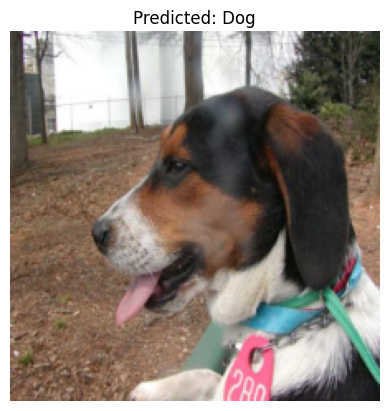

In [12]:
import random

dataset = datasets.ImageFolder(data_dir, transform=val_transform)

def predict_random_image():
    # Get a random index from the dataset
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]

    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to the device

    # Make a prediction
    with torch.no_grad():
        outputs = model(img)  # Get model's output
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index

    # Map the predicted class index back to 'Cat' or 'Dog'
    class_names = dataset.classes
    predicted_class = class_names[predicted.item()]

    # Normalize the image back to [0, 1] for visualization
    img = img.squeeze(0).cpu()  # Remove batch dimension and move to CPU

    # Undo the normalization from the model
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])
    img = unnormalize(img)

    # Convert tensor to PIL image for display
    img = transforms.ToPILImage()(img)

    # Display the image
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Call the function to predict and display a random image
predict_random_image()

In [13]:
import qai_hub as hub

devices = [
    "Samsung Galaxy S22 Ultra 5G",
    "Samsung Galaxy S22 5G",
    "Samsung Galaxy S22+ 5G",
    "Samsung Galaxy Tab S8",
    "Xiaomi 12",
    "Xiaomi 12 Pro",
    "Samsung Galaxy S22 5G",
    "Samsung Galaxy S23",
    "Samsung Galaxy S23+",
    "Samsung Galaxy S23 Ultra",
    "Samsung Galaxy S24",
    "Samsung Galaxy S24 Ultra",
    "Samsung Galaxy S24+",
]
selected_device = random.choice(devices)
print(f"Selected device: {selected_device}")

Selected device: Samsung Galaxy S22 Ultra 5G


In [22]:
# Initialize the model and load the trained weights
# Not pre-trained because we are loading our weights
device_model = models.resnet18(pretrained=False)
device_model.fc = torch.nn.Linear(device_model.fc.in_features, 2)

# Save the model's state_dict
torch.save(model.state_dict(), "cats_and_dogs_model.pth")

# Load the trained weights
device_model.load_state_dict(torch.load("cats_and_dogs_model.pth"))
device_model.eval()

scripted_device_model = torch.jit.script(device_model)
# Save the scripted model to a file
scripted_device_model.save("cats_and_dogs_scripted.pt")

# Load the scripted model
uploaded_scripted_model = torch.jit.load("cats_and_dogs_scripted.pt")
uploaded_model = hub.upload_model(uploaded_scripted_model, name="Cats_and_Dogs_Model")

<ipython-input-22-e99481a9ccc5>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  device_model.load_state_dict(torch.load("cats_and_dogs_model.pth"))


Uploading tmphes66d2x.pt


100%|██████████| 42.8M/42.8M [00:02<00:00, 17.8MB/s]


In [23]:
hub_device = hub.Device(selected_device)

# Example input shape: (batch_size=1, channels=3, height=224, width=224)
input_shape_hub = (1, 3, 224, 224)  # ResNet18 expects 224x224 input images

# Submit the compile job
compile_job_hub = hub.submit_compile_job(
    uploaded_model,
    device=hub_device,
    name="Cats_and_Dogs_Model (1, 3, 224, 224)",
    input_specs=dict(x=input_shape_hub),
)

# Get the compiled model
compiled_device_model = compile_job_hub.get_target_model()

Scheduled compile job (jp2xmeqqg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp2xmeqqg/

Waiting for compile job (jp2xmeqqg) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


In [24]:
from qai_hub_models.utils.printing import print_profile_metrics_from_job

# Submit a performance profile job on the device
performance_profile_job = hub.submit_profile_job(
    model=compiled_device_model,
    device=hub_device,
)

# Download and print the profile metrics
performance_data = performance_profile_job.download_profile()
print_profile_metrics_from_job(performance_profile_job, performance_data)

Scheduled profile job (jp04r68ng) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp04r68ng/

Waiting for profile job (jp04r68ng) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          

------------------------------------------------------------
Performance results on-device for Job_Jp2Xmeqqg_Optimized_Tflite.
------------------------------------------------------------
Device                          : Samsung Galaxy S22 Ultra 5G (12)
Runtime                         : TFLITE                          
Estimated inference time (ms)   : 1.5                             
Estimated peak memory usage (MB): [0, 16]                         
Total # Ops                     : 37                              
Compute Unit(s)                 : NPU (37 ops)                    
------------------------------------------------------------
More details: https://app.aihub.qualcomm.com/jobs/jp04r68ng/



Selected image from 'Cat': PetImages/Cat/1949.jpg


Uploading dataset: 170kB [00:01, 152kB/s]                    


Scheduled inference job (jp8271dop) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp8271dop/

Waiting for inference job (jp8271dop) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          


tmpsj9ll28l.h5: 100%|██████████| 13.9k/13.9k [00:00<00:00, 12.2MB/s]

Predicted Label: Cat


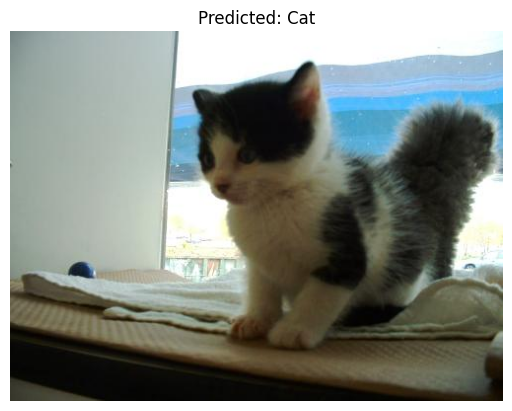

In [25]:
import numpy as np
from PIL import Image

class_names = ["Cat", "Dog"]

# Randomly choose a class folder
selected_class = random.choice(class_names)
class_dir = os.path.join(data_dir, selected_class)

image_files = [
    os.path.join(class_dir, fname)
    for fname in os.listdir(class_dir)
    if fname.lower().endswith('.jpg')
]

# Randomly select one image file
img_path = random.choice(image_files)
print(f"Selected image from '{selected_class}': {img_path}")

selected_image_pil = Image.open(img_path).convert("RGB")

# Define the transformation exactly as used during training
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Apply the transform to the raw image for inference
model_ready_input_tensor = inference_transform(selected_image_pil).unsqueeze(0)  # Add batch dimension

# Convert to numpy array
model_ready_input_numpy = model_ready_input_tensor.numpy().astype(np.float32)

# Prepare inputs for inference
inference_inputs = {"x": [model_ready_input_numpy]}

# Submit inference job
inference_job_hub = hub.submit_inference_job(
    model=compiled_device_model,
    inputs=inference_inputs,
    device=hub_device,
)

# Get inference results
ondevice_inference_output = inference_job_hub.download_output_data()
output_logits = ondevice_inference_output["output_0"][0]

# Determine the predicted class
predicted_class_index = np.argmax(output_logits)
predicted_class = class_names[predicted_class_index]

print(f"Predicted Label: {predicted_class}")

plt.imshow(selected_image_pil)
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')